In [1]:
import math
import os
import time

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from model import aagcn, loss, SAM
from utils import adj_mat, training_supervision
from data.handpose_dataset import HandPoseDatasetNumpy, df_to_numpy
from data.get_data_from_csv import get_train_data, get_val_data
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import sklearn
from config_fine_tuning_occluded_hand_detection import CFG

Import model

In [3]:
model_path = 'trained_models/7_AAGCN_Focal_seqlen32_release_SAM_joints1_joints2_oridist/f10.8142688679245284_valloss310.2437744140625_epoch13.pth'

graph = aagcn.Graph(adj_mat.num_node, adj_mat.self_link, adj_mat.inward, adj_mat.outward, adj_mat.neighbor)

model = aagcn.Model(num_class=CFG.num_classes, num_point=21, num_person=1, graph=graph, drop_out=0.5,
                    in_channels=CFG.num_feats)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


Model(
  (data_bn): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): TCN_GCN_unit(
    (gcn1): unit_gcn(
      (conv_d): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_a): ModuleList(
        (0-2): 3 x Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_b): ModuleList(
        (0-2): 3 x Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_ta): Conv1d(64, 1, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv_sa): Conv1d(64, 1, kernel_size=(21,), stride=(1,), padding=(10,))
      (fc1c): Linear(in_features=64, out_features=32, bias=True)
      (fc2c): Linear(in_features=32, out_features=64, bias=True)
      (down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Modify model -> only the classes we want for our model

In [4]:
# change last layer
model.fc = nn.Linear(128, CFG.num_classes_fine_tuning).to(device)

# init the new layer
nn.init.normal_(model.fc.weight, 0, math.sqrt(2. / CFG.num_classes_fine_tuning))

Parameter containing:
tensor([[-1.0669,  0.9428,  0.3818,  1.4602,  0.4804,  0.3955,  0.6410,  0.1262,
          0.3185,  1.9670, -0.5940, -1.2685,  1.2133,  0.6034, -0.7380,  0.3371,
          1.5708,  0.1047, -0.2303, -2.2158,  0.2992,  0.6630, -1.3477, -0.8097,
         -0.2257,  1.4778, -1.0368, -0.0829,  0.5372, -0.0712,  0.0575, -0.6844,
         -0.4195,  0.9483,  0.2217, -0.5214, -0.5307,  0.3592,  0.2241, -0.1499,
         -0.5090,  2.1777, -1.1670, -2.5790, -0.7566, -0.9087, -0.1022,  0.2798,
          1.2649,  0.9523, -0.6124,  0.8638,  0.8919, -1.8456, -0.5453,  1.6739,
         -2.0131, -0.6230,  1.2416, -1.9431, -0.1925, -0.4736, -1.0321, -0.6609,
          0.8556,  0.1153, -1.2600, -1.7402, -1.3755, -1.4558, -0.0315, -0.5076,
          2.3376, -0.3060,  1.1145,  0.4076,  0.8881,  0.5910,  0.9468,  0.6558,
          1.1582,  0.4882,  1.0668,  0.2553, -0.9383,  0.7608,  1.4542, -1.5645,
          1.3917,  0.1273,  0.5217, -0.1578, -1.7956, -0.0401, -1.5828,  0.0816,
      

Get data

In [5]:
from sklearn.model_selection import train_test_split

df_custom_data = pd.read_csv("data/graphdata/custom_data/WinkenDaumenHochDataset.csv")
df_custom_data['LABEL'] = df_custom_data['LABEL'].replace({'Winken': 'Wave', 'DaumenHoch': 'ThumbsUp'})


unique_gestures_start_indices = df_custom_data[df_custom_data['Unnamed: 0'] == 0].index

train_start_indices, test_start_indices = train_test_split(unique_gestures_start_indices, test_size=0.3, random_state=42)

def extract_gesture_data(df, start_indices):
    shuffled_indices = sklearn.utils.shuffle(start_indices, random_state=42)
    frames = []
    for idx in shuffled_indices:
        frames.extend(range(idx, idx + 32))
    return df.loc[frames]

df_train = extract_gesture_data(df_custom_data, train_start_indices)
df_test = extract_gesture_data(df_custom_data, test_start_indices)

df_train = df_train.drop("Unnamed: 0", axis=1).reset_index(drop=True)
df_test = df_test.drop("Unnamed: 0", axis=1).reset_index(drop=True)

print("[INFO] TRAIN DATA DISTRIBUTION")
print(df_train["LABEL"].value_counts())
print("[INFO] TEST DATA DISTRIBUTION")
print(df_test["LABEL"].value_counts())

df_train.head(20)

[INFO] TRAIN DATA DISTRIBUTION
LABEL
Wave        2208
ThumbsUp    2112
Name: count, dtype: int64
[INFO] TEST DATA DISTRIBUTION
LABEL
Wave        1120
ThumbsUp     736
Name: count, dtype: int64


,WRIST,THUMB_CMC,THUMB_MCP,THUMB_IP,THUMB_TIP,INDEX_FINGER_MCP,INDEX_FINGER_PIP,INDEX_FINGER_DIP,INDEX_FINGER_TIP,MIDDLE_FINGER_MCP,...,MIDDLE_FINGER_TIP,RING_FINGER_MCP,RING_FINGER_PIP,RING_FINGER_DIP,RING_FINGER_TIP,PINKY_MCP,PINKY_PIP,PINKY_DIP,PINKY_TIP,LABEL
0,"(0.35, 1.23, 0.11)","(0.32, 1.24, 0.11)","(0.27, 1.26, 0.11)","(0.25, 1.28, 0.11)","(0.25, 1.29, 0.11)","(0.29, 1.31, 0.11)","(0.27, 1.33, 0.12)","(0.26, 1.35, 0.12)","(0.25, 1.36, 0.13)","(0.30, 1.31, 0.12)",...,"(0.27, 1.39, 0.13)","(0.32, 1.31, 0.13)","(0.31, 1.35, 0.13)","(0.31, 1.37, 0.14)","(0.30, 1.38, 0.14)","(0.33, 1.31, 0.14)","(0.33, 1.33, 0.14)","(0.33, 1.35, 0.14)","(0.33, 1.37, 0.14)",Wave
1,"(0.34, 1.24, 0.11)","(0.31, 1.24, 0.11)","(0.27, 1.26, 0.10)","(0.25, 1.27, 0.10)","(0.24, 1.29, 0.10)","(0.28, 1.31, 0.11)","(0.26, 1.33, 0.11)","(0.24, 1.34, 0.11)","(0.23, 1.36, 0.12)","(0.29, 1.31, 0.11)",...,"(0.25, 1.38, 0.12)","(0.31, 1.32, 0.12)","(0.30, 1.35, 0.13)","(0.29, 1.37, 0.13)","(0.28, 1.38, 0.13)","(0.32, 1.31, 0.13)","(0.32, 1.34, 0.13)","(0.31, 1.36, 0.14)","(0.31, 1.37, 0.14)",Wave
2,"(0.34, 1.24, 0.11)","(0.31, 1.25, 0.11)","(0.27, 1.27, 0.10)","(0.25, 1.29, 0.10)","(0.24, 1.30, 0.11)","(0.28, 1.31, 0.11)","(0.27, 1.34, 0.11)","(0.25, 1.35, 0.12)","(0.24, 1.37, 0.12)","(0.30, 1.32, 0.11)",...,"(0.26, 1.39, 0.13)","(0.31, 1.32, 0.12)","(0.30, 1.36, 0.13)","(0.29, 1.38, 0.13)","(0.29, 1.39, 0.14)","(0.33, 1.32, 0.14)","(0.33, 1.35, 0.14)","(0.32, 1.36, 0.14)","(0.32, 1.37, 0.14)",Wave
3,"(0.37, 1.24, 0.11)","(0.35, 1.25, 0.12)","(0.30, 1.27, 0.11)","(0.29, 1.28, 0.11)","(0.28, 1.30, 0.11)","(0.32, 1.31, 0.11)","(0.30, 1.33, 0.11)","(0.29, 1.35, 0.12)","(0.28, 1.36, 0.13)","(0.33, 1.32, 0.11)",...,"(0.30, 1.39, 0.13)","(0.35, 1.32, 0.12)","(0.34, 1.35, 0.13)","(0.33, 1.37, 0.13)","(0.33, 1.38, 0.14)","(0.36, 1.32, 0.13)","(0.37, 1.34, 0.13)","(0.37, 1.36, 0.13)","(0.36, 1.37, 0.14)",Wave
4,"(0.39, 1.25, 0.12)","(0.36, 1.27, 0.13)","(0.33, 1.30, 0.13)","(0.31, 1.32, 0.13)","(0.31, 1.33, 0.13)","(0.36, 1.33, 0.13)","(0.35, 1.36, 0.13)","(0.34, 1.38, 0.14)","(0.34, 1.39, 0.15)","(0.37, 1.34, 0.13)",...,"(0.36, 1.41, 0.15)","(0.39, 1.33, 0.14)","(0.39, 1.37, 0.14)","(0.39, 1.38, 0.15)","(0.39, 1.40, 0.16)","(0.40, 1.32, 0.14)","(0.41, 1.35, 0.14)","(0.42, 1.37, 0.15)","(0.42, 1.38, 0.16)",Wave
5,"(0.38, 1.27, 0.13)","(0.35, 1.29, 0.13)","(0.33, 1.32, 0.14)","(0.31, 1.34, 0.14)","(0.31, 1.35, 0.15)","(0.35, 1.35, 0.14)","(0.34, 1.38, 0.15)","(0.34, 1.40, 0.16)","(0.34, 1.41, 0.16)","(0.37, 1.35, 0.14)",...,"(0.36, 1.42, 0.17)","(0.38, 1.35, 0.15)","(0.39, 1.38, 0.15)","(0.39, 1.40, 0.16)","(0.39, 1.41, 0.17)","(0.40, 1.34, 0.15)","(0.41, 1.36, 0.15)","(0.41, 1.38, 0.16)","(0.41, 1.39, 0.16)",Wave
6,"(0.37, 1.27, 0.12)","(0.34, 1.28, 0.13)","(0.31, 1.31, 0.14)","(0.30, 1.33, 0.14)","(0.30, 1.35, 0.15)","(0.34, 1.35, 0.14)","(0.33, 1.38, 0.15)","(0.33, 1.40, 0.16)","(0.32, 1.41, 0.16)","(0.35, 1.35, 0.14)",...,"(0.35, 1.42, 0.17)","(0.37, 1.35, 0.15)","(0.38, 1.38, 0.15)","(0.38, 1.40, 0.16)","(0.38, 1.41, 0.17)","(0.39, 1.34, 0.15)","(0.40, 1.36, 0.15)","(0.40, 1.38, 0.16)","(0.40, 1.39, 0.16)",Wave
7,"(0.34, 1.25, 0.12)","(0.31, 1.26, 0.12)","(0.27, 1.29, 0.13)","(0.26, 1.30, 0.13)","(0.25, 1.32, 0.14)","(0.30, 1.33, 0.13)","(0.28, 1.35, 0.14)","(0.28, 1.37, 0.14)","(0.27, 1.38, 0.15)","(0.31, 1.33, 0.13)",...,"(0.30, 1.40, 0.15)","(0.33, 1.33, 0.14)","(0.33, 1.36, 0.14)","(0.33, 1.38, 0.15)","(0.32, 1.39, 0.16)","(0.34, 1.32, 0.14)","(0.35, 1.34, 0.14)","(0.35, 1.36, 0.15)","(0.35, 1.37, 0.16)",Wave
8,"(0.33, 1.24, 0.11)","(0.30, 1.25, 0.12)","(0.26, 1.27, 0.12)","(0.24, 1.29, 0.12)","(0.24, 1.30, 0.13)","(0.27, 1.31, 0.12)","(0.26, 1.34, 0.13)","(0.25, 1.36, 0.13)","(0.24, 1.37, 0.14)","(0.29, 1.32, 0.13)",...,"(0.27, 1.39, 0.14)","(0.31, 1.32, 0.14)","(0.30, 1.35, 0.14)","(0.30, 1.37, 0.14)","(0.29, 1.38, 0.15)","(0.32, 1.31, 0.14)","(0.32, 1.34, 0.14)","(0.32, 1.35, 0.15)","(0.32, 1.37, 0.15)",Wave
9,"(0.31, 1.23, 0.12)","(0.28, 1.24, 0.11)","(

Finetuning first try: remove all other classes except the classes we want to have in our model

In [6]:
#df_train = df_train[df_train["LABEL"].isin(CFG.classes_fine_tuning)]
#df_val = df_val[df_val["LABEL"].isin(CFG.classes_fine_tuning)]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   WRIST              4320 non-null   object
 1   THUMB_CMC          4320 non-null   object
 2   THUMB_MCP          4320 non-null   object
 3   THUMB_IP           4320 non-null   object
 4   THUMB_TIP          4320 non-null   object
 5   INDEX_FINGER_MCP   4320 non-null   object
 6   INDEX_FINGER_PIP   4320 non-null   object
 7   INDEX_FINGER_DIP   4320 non-null   object
 8   INDEX_FINGER_TIP   4320 non-null   object
 9   MIDDLE_FINGER_MCP  4320 non-null   object
 10  MIDDLE_FINGER_PIP  4320 non-null   object
 11  MIDDLE_FINGER_DIP  4320 non-null   object
 12  MIDDLE_FINGER_TIP  4320 non-null   object
 13  RING_FINGER_MCP    4320 non-null   object
 14  RING_FINGER_PIP    4320 non-null   object
 15  RING_FINGER_DIP    4320 non-null   object
 16  RING_FINGER_TIP    4320 non-null   object


Prepare train and validation data

In [9]:
print("[INFO] TRAIN DATA DISTRIBUTION")
print(df_train["LABEL"].value_counts())
print("[INFO] VALIDATION DATA DISTRIBUTION")
print(df_test["LABEL"].value_counts())

train_numpy = df_to_numpy(df_train)
val_numpy = df_to_numpy(df_test)

train_set = HandPoseDatasetNumpy(train_numpy)
val_set = HandPoseDatasetNumpy(val_numpy)

train_loader = DataLoader(train_set, batch_size=CFG.batch_size, drop_last=True, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=CFG.batch_size, drop_last=True, shuffle=False, pin_memory=True)

print(f"[INFO] TRAINING ON {len(train_set)} DATAPOINTS")
print(f"[INFO] VALIDATION ON {len(val_set)} DATAPOINTS")


[INFO] TRAIN DATA DISTRIBUTION
LABEL
Wave        2208
ThumbsUp    2112
Name: count, dtype: int64
[INFO] VALIDATION DATA DISTRIBUTION
LABEL
Wave        1120
ThumbsUp     736
Name: count, dtype: int64
df_to_numpy: Original labels: [['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 ['Wave']
 

Fine tuning config and preparation

In [11]:
optimizer_base = torch.optim.Adam
optimizer = SAM.SAM(model.parameters(), optimizer_base, lr=CFG.lr, rho=0.5, adaptive=True)
criterion = loss.FocalLoss()


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=CFG.min_lr)

In [12]:
def train_func(model, data_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    iters = len(data_loader)
    global_step = epoch * len(data_loader)
    preds = []
    groundtruth = []
    t0 = time.time()
    loss_total = 0
    for i, (inputs, labels) in enumerate(data_loader):
        labels = labels.cuda().long()
        inputs = inputs.cuda().float()

        last_label = labels[:, -1, :].squeeze()
        #last_label = labels[:, -1, :]
        #last_label = torch.argmax(last_label, 1)
        
        #print("TRAIN Labels shape:", labels.shape)
        #print("Last label shape:", last_label.shape)
        #print("First 10 labels:", labels[:10])
        #print("First 10 last labels:", last_label[:10])

        model.zero_grad()
        last_out = model(inputs)

        # first forward-backward pass
        loss = criterion(last_out, last_label)
        loss.backward()

        if CFG.sam:
            optimizer.first_step(zero_grad=True)  #

            # second forward-backward pass
            criterion(model(inputs), last_label).backward()  #
            optimizer.second_step(zero_grad=True)  #
        else:
            optimizer.step()

        current_lr = optimizer.param_groups[0]['lr']

        preds.append(last_out.cpu().detach().numpy())
        groundtruth.append(last_label.cpu().detach().numpy())

        loss_total += loss
        global_step += 1
        

        if i % CFG.print_freq == 1 or i == iters - 1:
            t1 = time.time()
            print(
                f"[TRAIN] Epoch: {epoch}/{CFG.epochs} | Iteration: {i}/{iters} | Loss: {loss_total / i} | LR: {current_lr} | ETA: {((t1 - t0) / i * iters) - (t1 - t0)}s")

    return loss_total, np.argmax(preds, axis=2).flatten(), np.array(groundtruth).flatten()


def eval_func(model, criterion, data_loader, epoch):
    model.eval()
    preds = []
    groundtruth = []
    t0 = time.time()
    loss_total = 0
    global_step = len(train_loader) * epoch
    iters = len(data_loader)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            labels = labels.cuda().long()
            inputs = inputs.cuda().float()
            last_label = labels[:, -1, :].squeeze()
            #last_label = labels[:, -1, :]
            #print("\nLastLabel labels[:, -1, :]: ", last_label)
            #last_label = torch.argmax(last_label, dim=1)

            #print("EVAL Labels shape:", labels.shape)
            #print("Last label shape:", last_label.shape)
            #print("First 500 labels:", labels[:500])
            #print("First 500 last labels:", last_label[:500])

            last_out = model(inputs)
            loss = criterion(last_out, last_label)

            preds.append(last_out.cpu().detach().numpy())
            groundtruth.append(last_label.cpu().detach().numpy())
            loss_total += loss

            if i % CFG.print_freq == 1 or i == iters - 1:
                t1 = time.time()
                print(
                    f"[EVAL] Epoch: {epoch}/{CFG.epochs} | Iteration: {i}/{iters} | Val-Loss: {loss_total / i} | ETA: {((t1 - t0) / i * iters) - (t1 - t0)}s")

    return loss_total, np.argmax(preds, axis=2).flatten(), np.array(groundtruth).flatten()

Start Fine tuning

[TRAIN] Epoch: 0/500 | Iteration: 1/332 | Loss: 1.3840134143829346 | LR: 0.0001 | ETA: 424.5250289440155s
[TRAIN] Epoch: 0/500 | Iteration: 101/332 | Loss: 0.5019794702529907 | LR: 0.0001 | ETA: 53.468154288754604s
[TRAIN] Epoch: 0/500 | Iteration: 201/332 | Loss: 0.33814021944999695 | LR: 0.0001 | ETA: 29.324172698443206s
[TRAIN] Epoch: 0/500 | Iteration: 301/332 | Loss: 0.2772681415081024 | LR: 0.0001 | ETA: 6.870945582754189s
[TRAIN] Epoch: 0/500 | Iteration: 331/332 | Loss: 0.26568832993507385 | LR: 0.0001 | ETA: 0.22226779338457447s
[TRAIN] Training F1-Score 0.6075069508804448
[EVAL] Epoch: 0/500 | Iteration: 1/142 | Val-Loss: 0.14990808069705963 | ETA: 8.867127656936646s


C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[EVAL] Epoch: 0/500 | Iteration: 101/142 | Val-Loss: 0.1647203117609024 | ETA: 1.4453477694256467s
[EVAL] Epoch: 0/500 | Iteration: 141/142 | Val-Loss: 0.16181211173534393 | ETA: 0.03391585958764942s
[EVAL] Validation F1-Score Micro 0.7258938244853739
[EVAL] Validation F1-Score Macro 0.6589210806136876
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.894     0.355     0.508       736
    ThumbsUp      0.694     0.972     0.810      1110

    accuracy                          0.726      1846
   macro avg      0.794     0.663     0.659      1846
weighted avg      0.774     0.726     0.690      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.7258938244853739_valloss22.815507888793945_epoch0.pth
[TRAIN] Epoch: 1/500 | Iteration: 1/332 | Loss: 0.2379281222820282 | LR: 0.0001 | ETA: 150.6381196975708s
[TRAIN] Epoch: 1/500 | Iteration: 101/332 | L

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.7469879518072289
[EVAL] Epoch: 1/500 | Iteration: 1/142 | Val-Loss: 0.14905481040477753 | ETA: 8.867497444152832s
[EVAL] Epoch: 1/500 | Iteration: 101/142 | Val-Loss: 0.141797736287117 | ETA: 1.2027018329884749s
[EVAL] Epoch: 1/500 | Iteration: 141/142 | Val-Loss: 0.1425095498561859 | ETA: 0.029245870333190815s
[EVAL] Validation F1-Score Micro 0.7551462621885158
[EVAL] Validation F1-Score Macro 0.7094626121037979
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.876     0.450     0.594       736
    ThumbsUp      0.724     0.958     0.825      1110

    accuracy                          0.755      1846
   macro avg      0.800     0.704     0.709      1846
weighted avg      0.785     0.755     0.733      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.7551462621885158_valloss20.093847274780273_epoch1.pth
[TRAIN] Ep

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.8000463392029658
[EVAL] Epoch: 2/500 | Iteration: 1/142 | Val-Loss: 0.1404908150434494 | ETA: 8.446074485778809s
[EVAL] Epoch: 2/500 | Iteration: 101/142 | Val-Loss: 0.13126711547374725 | ETA: 1.2035695963566848s
[EVAL] Epoch: 2/500 | Iteration: 141/142 | Val-Loss: 0.13363471627235413 | ETA: 0.029089907382396696s
[EVAL] Validation F1-Score Micro 0.7849404117009751
[EVAL] Validation F1-Score Macro 0.7489437723419599
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.912     0.510     0.654       736
    ThumbsUp      0.748     0.968     0.844      1110

    accuracy                          0.785      1846
   macro avg      0.830     0.739     0.749      1846
weighted avg      0.814     0.785     0.768      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.7849404117009751_valloss18.84249496459961_epoch2.pth
[TRAIN] E

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.8211306765523633
[EVAL] Epoch: 3/500 | Iteration: 1/142 | Val-Loss: 0.13105317950248718 | ETA: 8.868875741958618s
[EVAL] Epoch: 3/500 | Iteration: 101/142 | Val-Loss: 0.12428633868694305 | ETA: 1.5349927774750363s
[EVAL] Epoch: 3/500 | Iteration: 141/142 | Val-Loss: 0.12667429447174072 | ETA: 0.035501838575863864s
[EVAL] Validation F1-Score Micro 0.8055254604550379
[EVAL] Validation F1-Score Macro 0.7790507752396734
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.900     0.576     0.703       736
    ThumbsUp      0.773     0.958     0.856      1110

    accuracy                          0.806      1846
   macro avg      0.837     0.767     0.779      1846
weighted avg      0.824     0.806     0.795      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.8055254604550379_valloss17.86107635498047_epoch3.pth
[TRAIN] 

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.8526413345690455
[EVAL] Epoch: 4/500 | Iteration: 1/142 | Val-Loss: 0.136408731341362 | ETA: 8.865816593170166s
[EVAL] Epoch: 4/500 | Iteration: 101/142 | Val-Loss: 0.11626406759023666 | ETA: 1.1925779592872852s
[EVAL] Epoch: 4/500 | Iteration: 141/142 | Val-Loss: 0.11923231184482574 | ETA: 0.028819292149645293s
[EVAL] Validation F1-Score Micro 0.8169014084507042
[EVAL] Validation F1-Score Macro 0.7980502456612787
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.864     0.641     0.736       736
    ThumbsUp      0.797     0.933     0.860      1110

    accuracy                          0.817      1846
   macro avg      0.831     0.787     0.798      1846
weighted avg      0.824     0.817     0.811      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.8169014084507042_valloss16.811756134033203_epoch4.pth
[TRAIN] E

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.8716404077849861
[EVAL] Epoch: 5/500 | Iteration: 1/142 | Val-Loss: 0.15427856147289276 | ETA: 8.865917444229126s
[EVAL] Epoch: 5/500 | Iteration: 101/142 | Val-Loss: 0.10589113086462021 | ETA: 1.1657021683041418s
[EVAL] Epoch: 5/500 | Iteration: 141/142 | Val-Loss: 0.10922601819038391 | ETA: 0.028496114920216975s
[EVAL] Validation F1-Score Micro 0.8342361863488624
[EVAL] Validation F1-Score Macro 0.8231597058735136
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.832     0.732     0.779       736
    ThumbsUp      0.836     0.902     0.867      1110

    accuracy                          0.834      1846
   macro avg      0.834     0.817     0.823      1846
weighted avg      0.834     0.834     0.832      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.8342361863488624_valloss15.400869369506836_epoch5.pth
[TRAIN]

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.9052363299351252
[EVAL] Epoch: 6/500 | Iteration: 1/142 | Val-Loss: 0.14169421792030334 | ETA: 6.6098792552948s
[EVAL] Epoch: 6/500 | Iteration: 101/142 | Val-Loss: 0.09783162921667099 | ETA: 1.1841896123225144s
[EVAL] Epoch: 6/500 | Iteration: 141/142 | Val-Loss: 0.09927194565534592 | ETA: 0.028788717080515447s
[EVAL] Validation F1-Score Micro 0.8450704225352113
[EVAL] Validation F1-Score Macro 0.8345256005215385
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.849     0.743     0.793       736
    ThumbsUp      0.843     0.913     0.876      1110

    accuracy                          0.845      1846
   macro avg      0.846     0.828     0.835      1846
weighted avg      0.845     0.845     0.843      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.8450704225352113_valloss13.997344970703125_epoch6.pth
[TRAIN] E

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.9309545875810936
[EVAL] Epoch: 7/500 | Iteration: 1/142 | Val-Loss: 0.16868236660957336 | ETA: 8.865984678268433s
[EVAL] Epoch: 7/500 | Iteration: 101/142 | Val-Loss: 0.09084279090166092 | ETA: 1.1904891717551953s
[EVAL] Epoch: 7/500 | Iteration: 141/142 | Val-Loss: 0.09203188866376877 | ETA: 0.028842785679701777s
[EVAL] Validation F1-Score Micro 0.8461538461538461
[EVAL] Validation F1-Score Macro 0.8398587556815406
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.804     0.812     0.808       736
    ThumbsUp      0.875     0.868     0.872      1110

    accuracy                          0.846      1846
   macro avg      0.839     0.840     0.840      1846
weighted avg      0.846     0.846     0.846      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.8461538461538461_valloss12.976496696472168_epoch7.pth
[TRAIN]

C:\Users\smujan\PycharmProjects\Hand-Gesture-Recognition-in-manual-assembly-tasks-using-GCN\utils\training_supervision.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=0, right=len(ave_grads))


[TRAIN] Training F1-Score 0.946014828544949
[EVAL] Epoch: 8/500 | Iteration: 1/142 | Val-Loss: 0.10380672663450241 | ETA: 7.8825860023498535s
[EVAL] Epoch: 8/500 | Iteration: 101/142 | Val-Loss: 0.09246809035539627 | ETA: 1.23626712525245s
[EVAL] Epoch: 8/500 | Iteration: 141/142 | Val-Loss: 0.09753938019275665 | ETA: 0.02983998237772134s
[EVAL] Validation F1-Score Micro 0.8466955579631636
[EVAL] Validation F1-Score Macro 0.8351262941461437
[EVAL] Classification Report
              precision    recall  f1-score   support

        Wave      0.865     0.730     0.791       736
    ThumbsUp      0.838     0.924     0.879      1110

    accuracy                          0.847      1846
   macro avg      0.851     0.827     0.835      1846
weighted avg      0.848     0.847     0.844      1846

[INFO] MODEL SAVED to fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.8466955579631636_valloss13.753052711486816_epoch8.pth
[TRAIN] Ep

KeyboardInterrupt: 

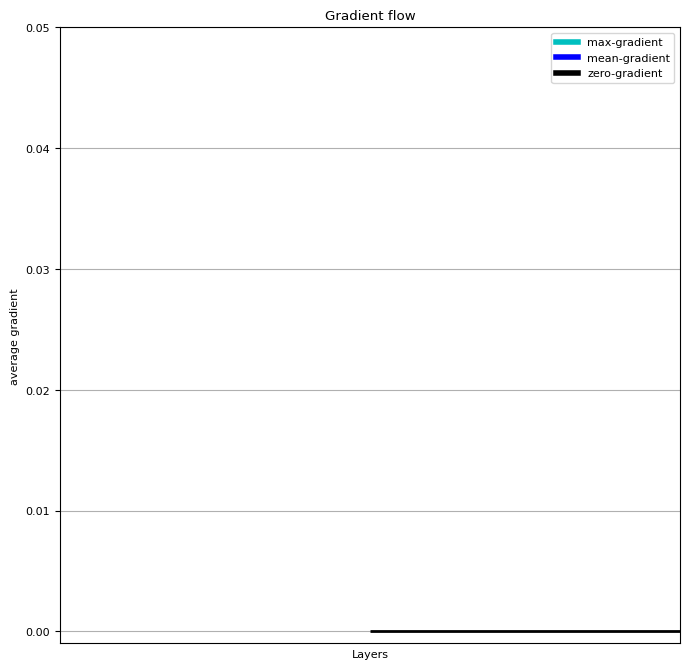

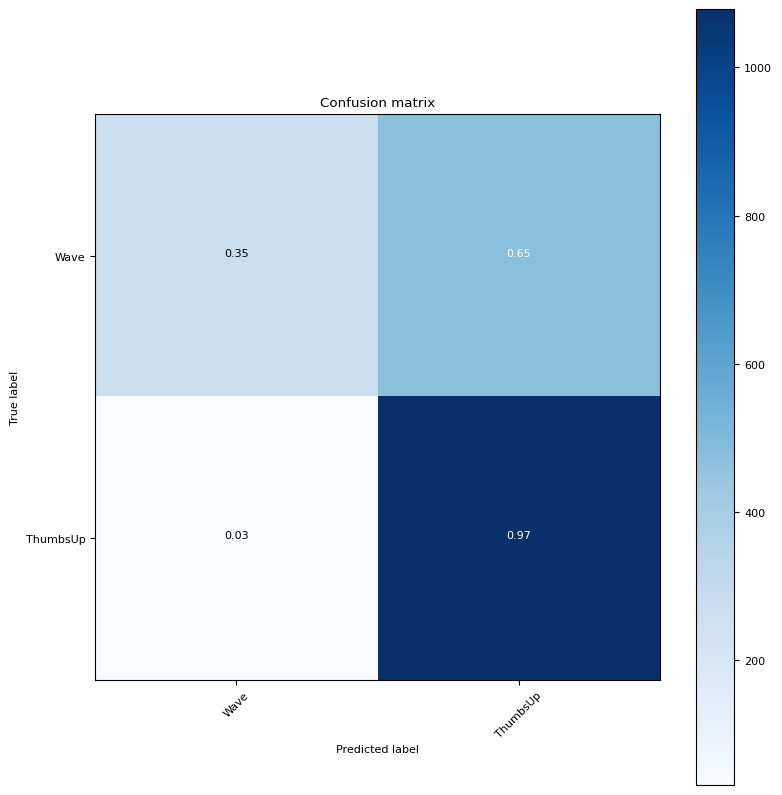

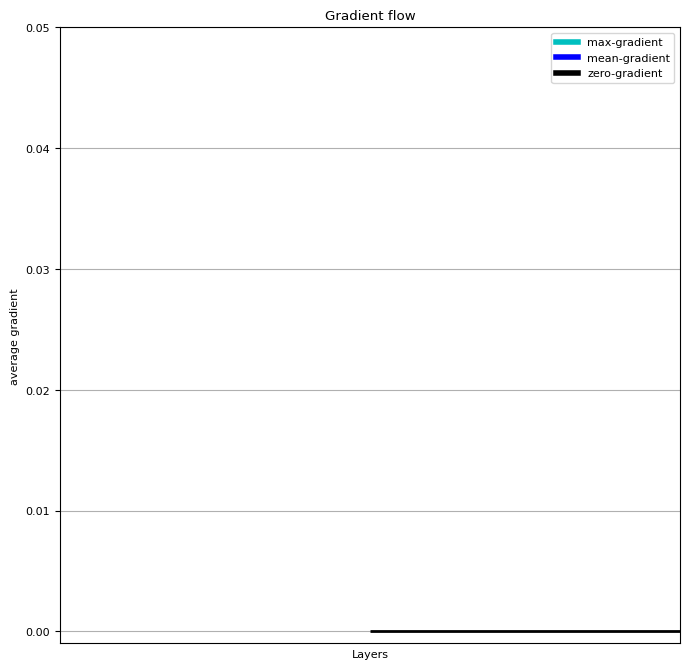

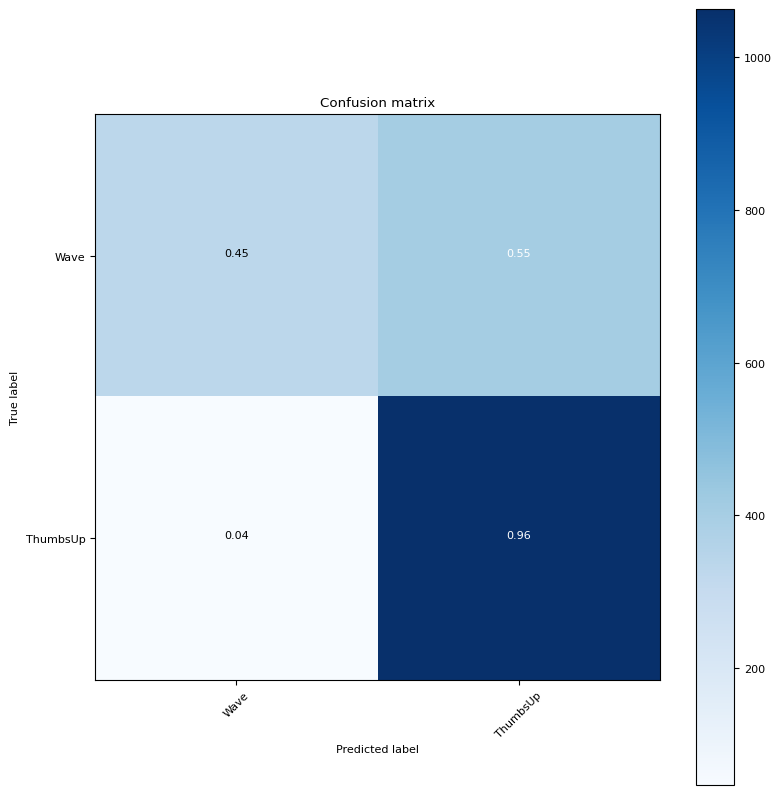

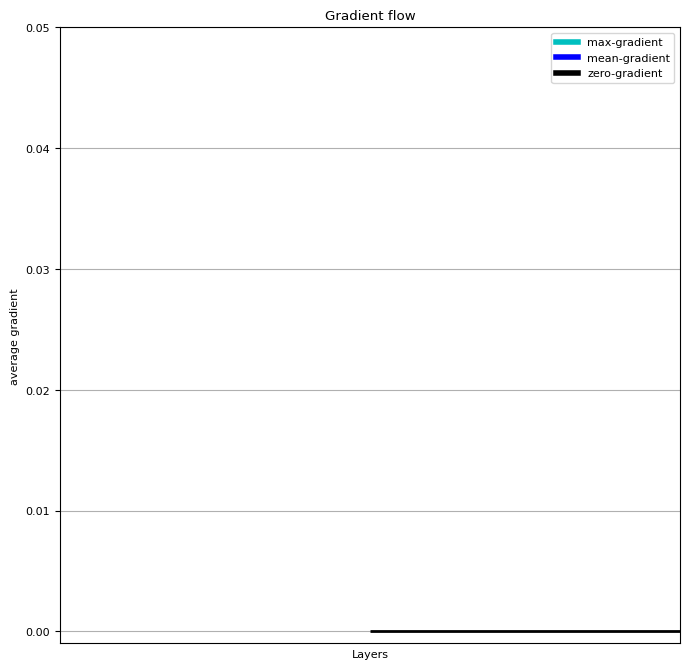

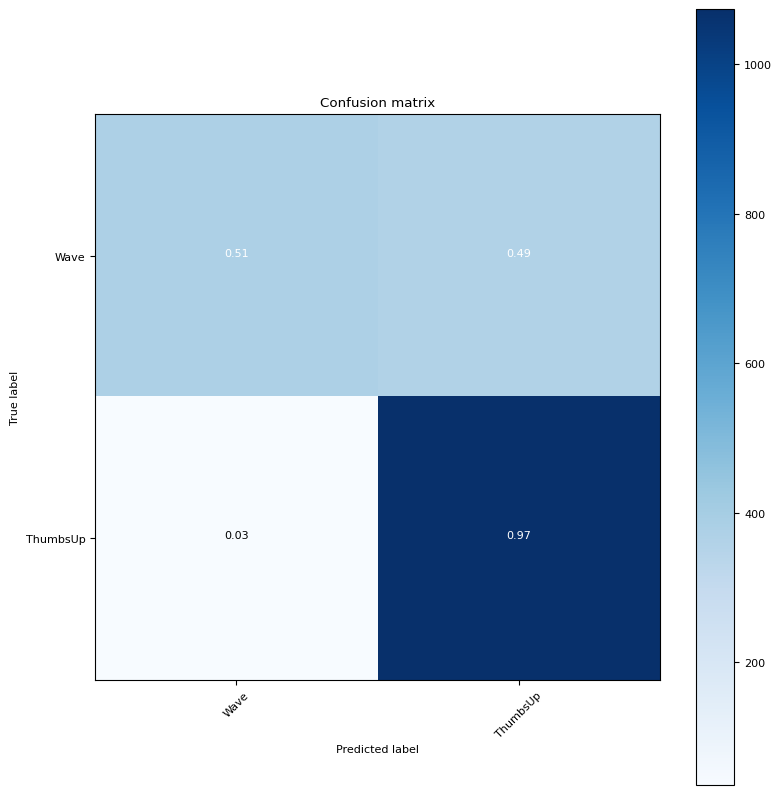

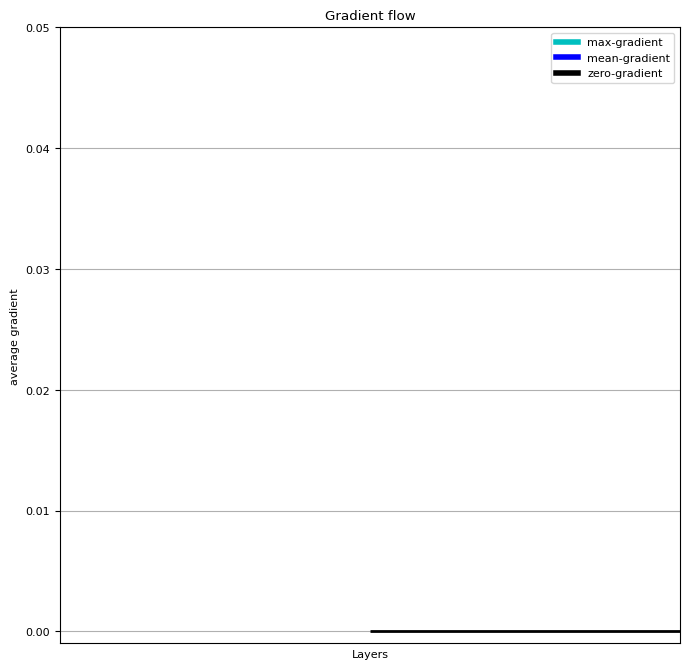

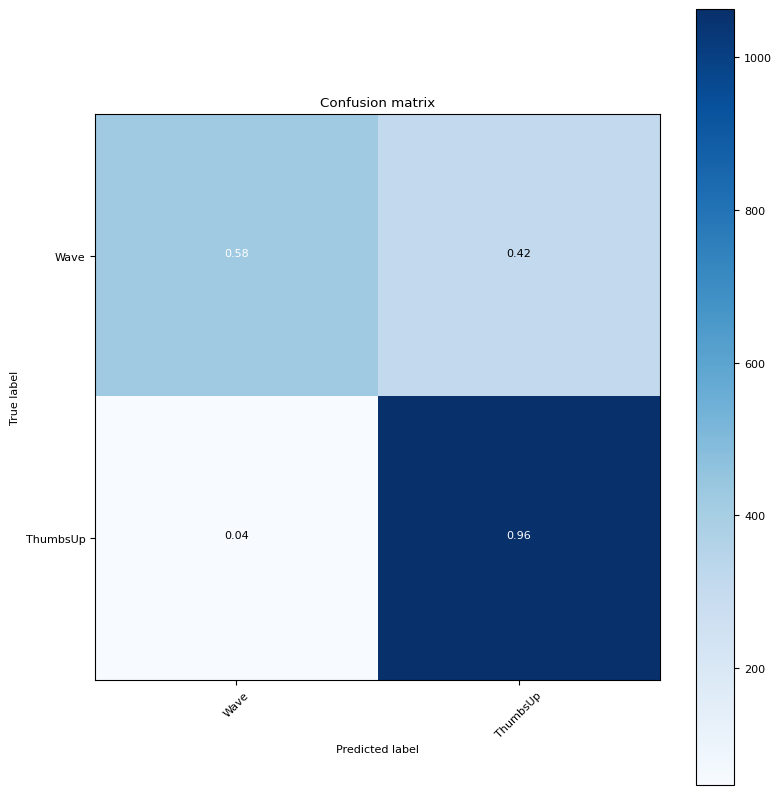

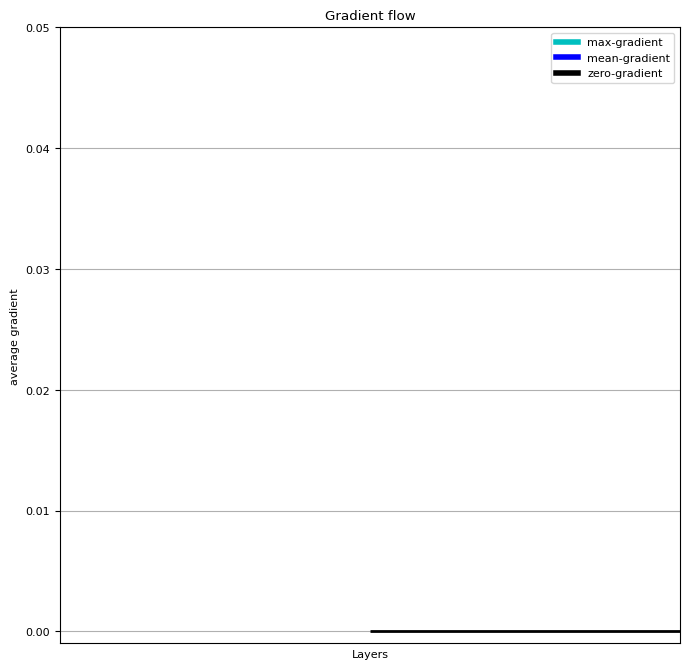

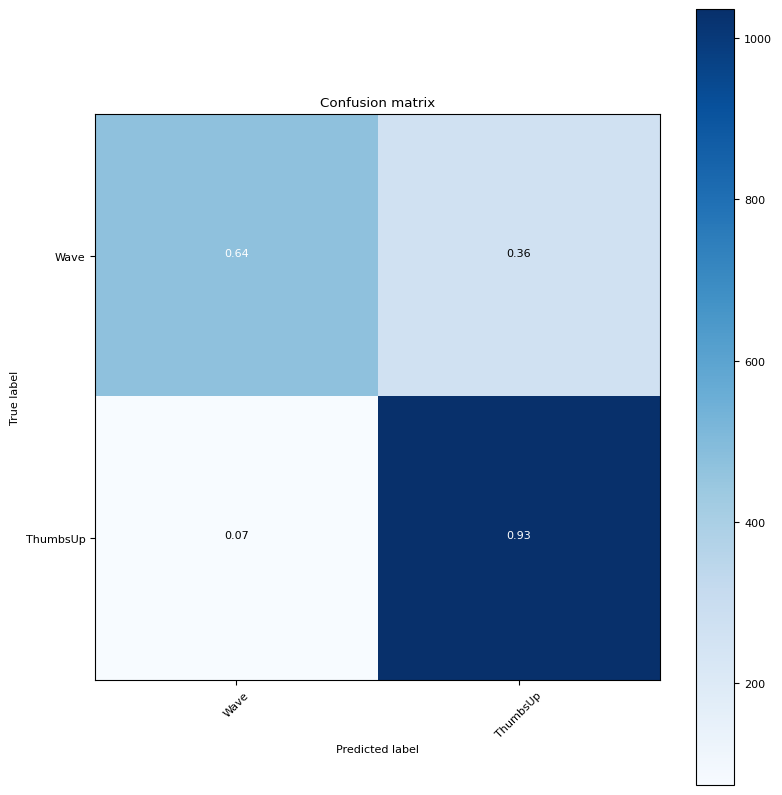

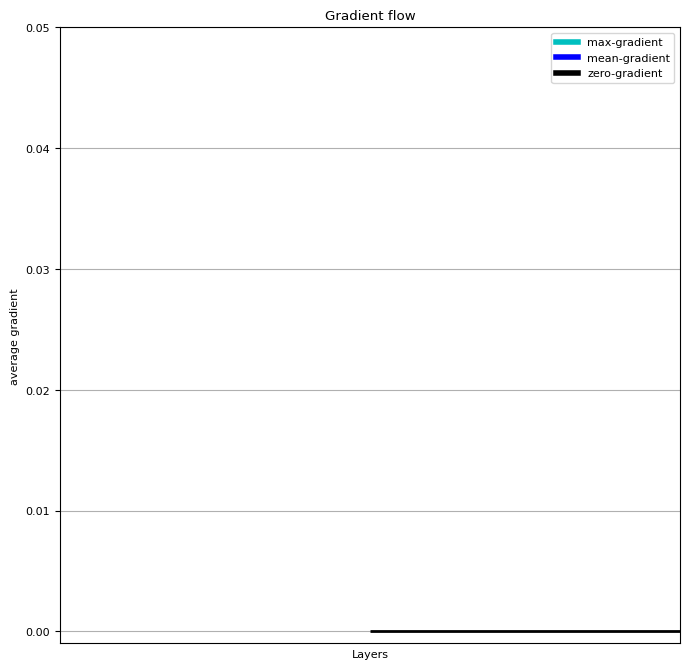

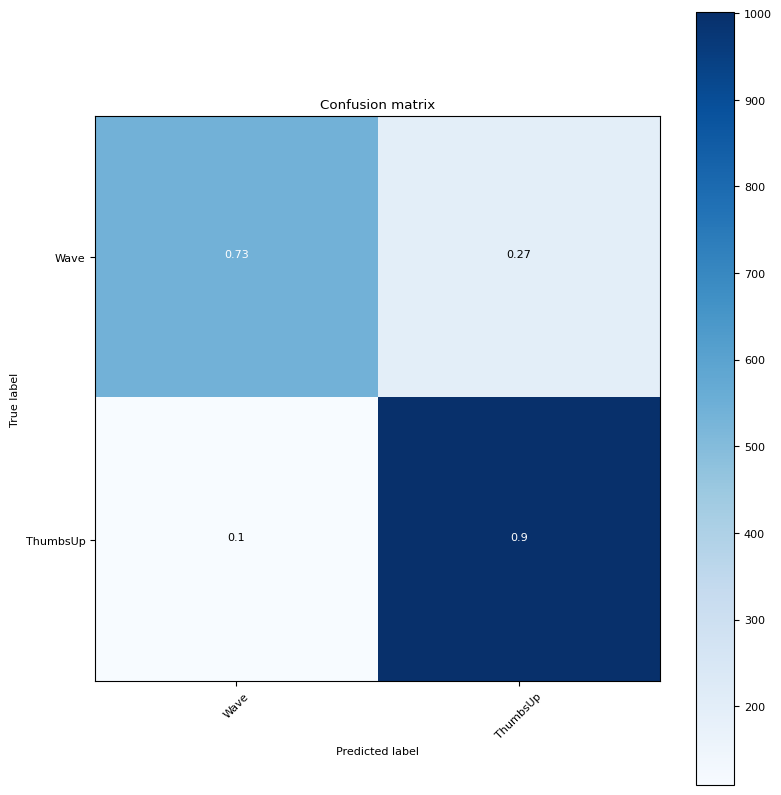

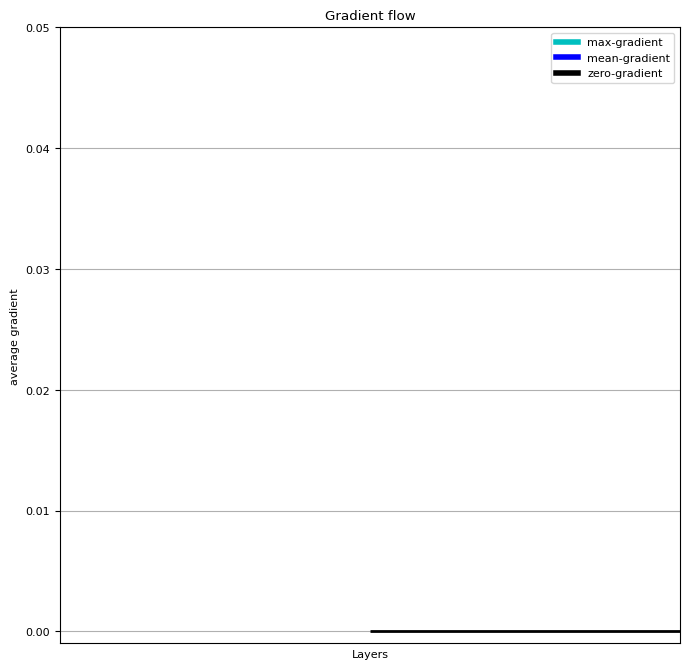

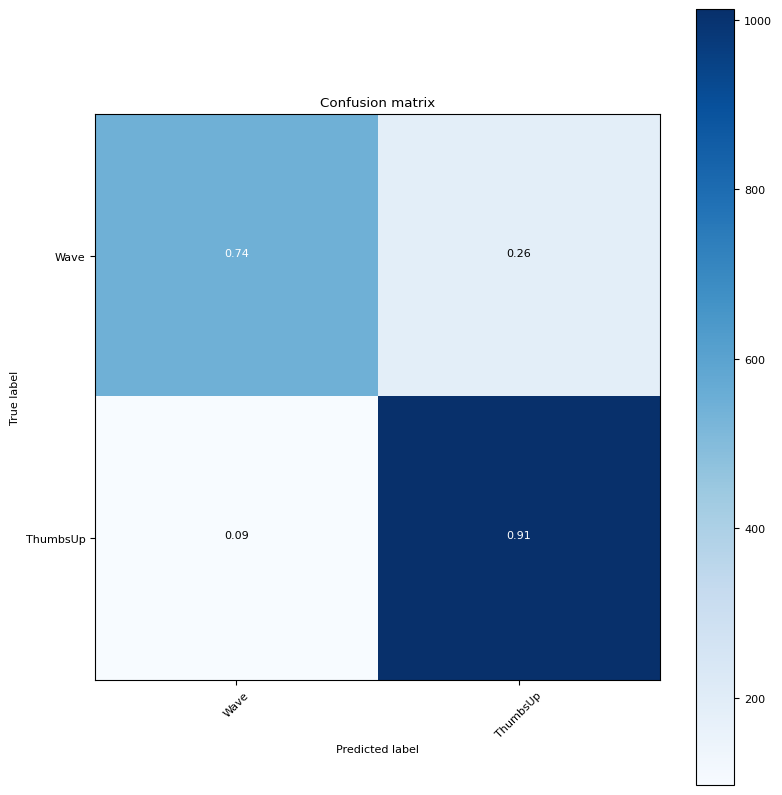

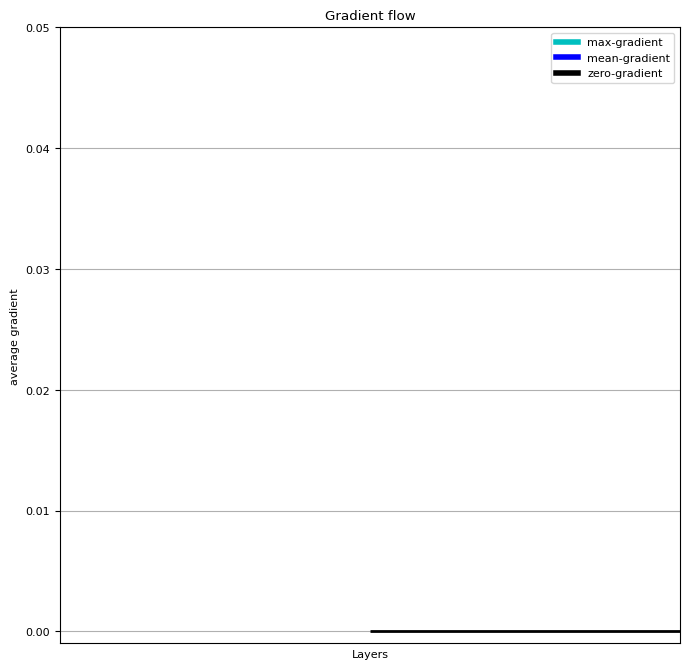

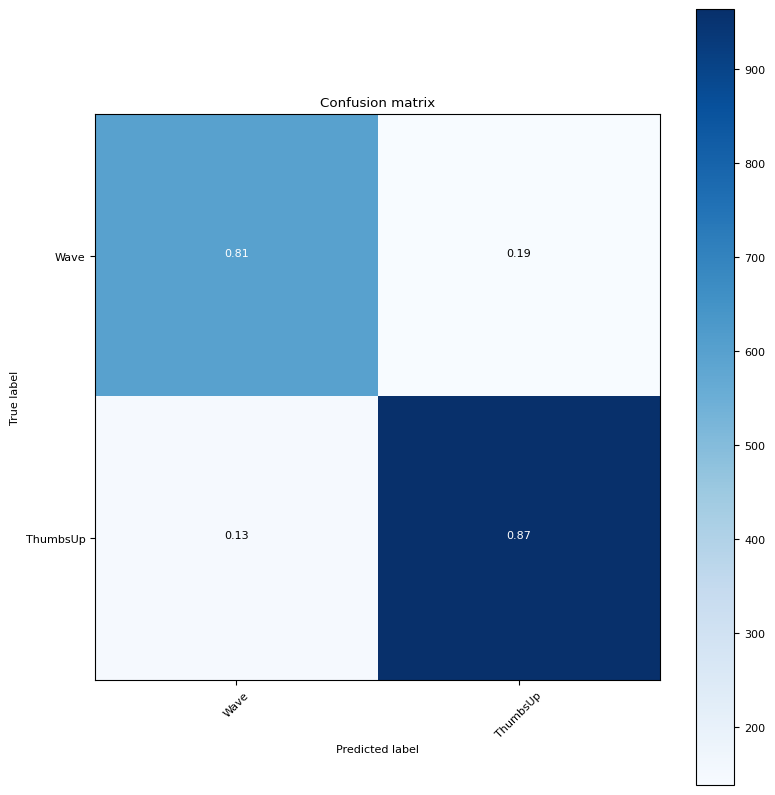

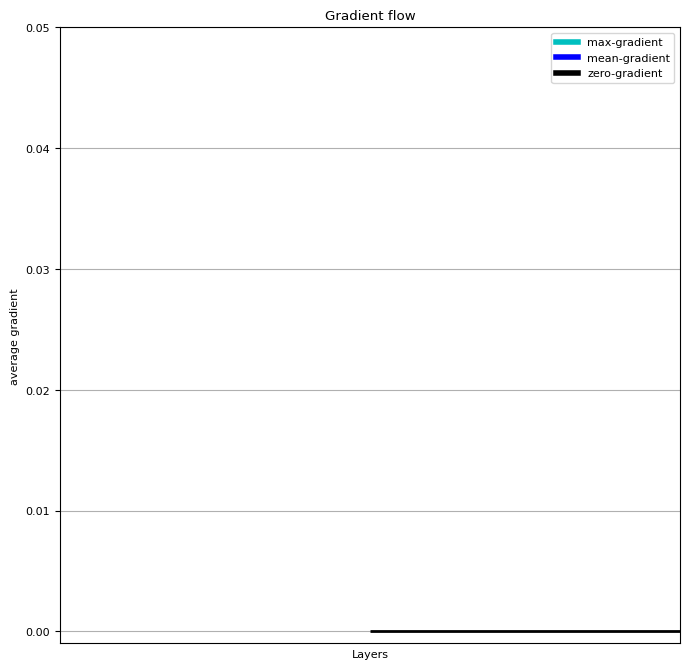

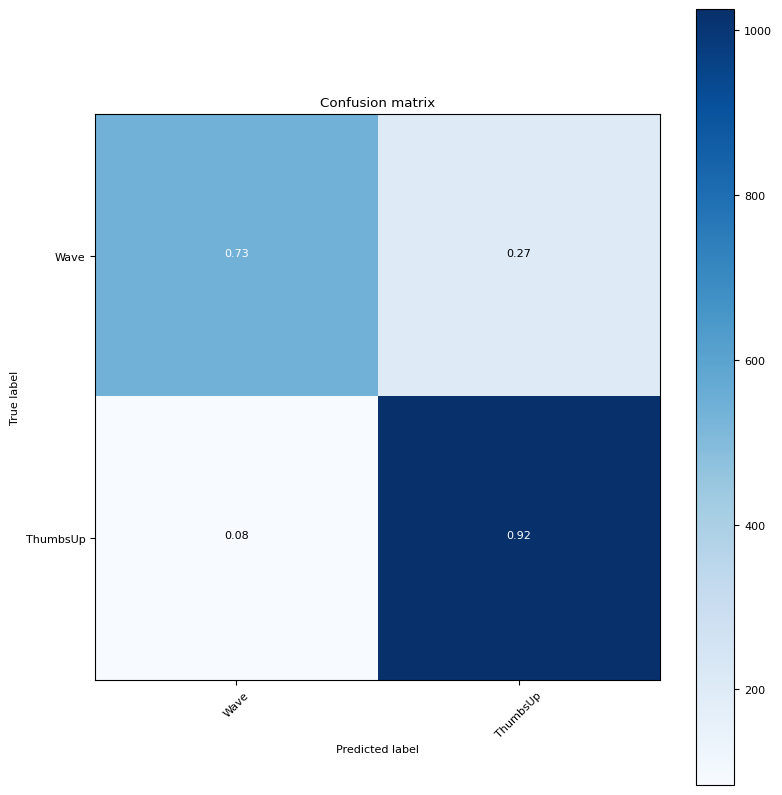

In [14]:
start_epoch = 0

for epoch in range(start_epoch, CFG.epochs + start_epoch):
    global_step = len(train_loader) * epoch

    #TRAIN
    train_loss, preds_train, gt_train = train_func(model, train_loader, criterion, optimizer, scheduler, epoch)
    train_grad_flow_plot = training_supervision.get_plot_grad_flow(model)

    f1_train = f1_score(gt_train, preds_train, average="micro")
    
    print(f"[TRAIN] Training F1-Score {f1_train}")

    #Model Gradients
    names, gradmean = training_supervision.get_model_grads(model)
    _limits = np.array([float(i) for i in range(len(gradmean))])
    _num = len(gradmean)
    

    #VAL
    val_loss, preds_val, gt_val = eval_func(model, criterion, val_loader, epoch)

    f1_val_micro = f1_score(gt_val, preds_val, average="micro")
    f1_val_macro = f1_score(gt_val, preds_val, average="macro")
    
    print(f"[EVAL] Validation F1-Score Micro {f1_val_micro}")
    print(f"[EVAL] Validation F1-Score Macro {f1_val_macro}")

    #Conf Mat
    cm = sklearn.metrics.confusion_matrix(gt_val, preds_val)
    cm_plot = training_supervision.plot_confusion_matrix(cm, CFG.classes_fine_tuning)
    

    #Model Weights
    names, params = training_supervision.get_model_weights(model)
    

    #print("Erste paar wahre Labels:", gt_val[:700])
    #print("Erste paar Vorhersagen:", preds_val[:700])
    
    print("[EVAL] Classification Report")
    #
    print(classification_report(gt_val, preds_val, target_names=CFG.classes_fine_tuning, digits=3))


    scheduler.step(val_loss)  #for reduce lr on plateau

    import os
    os.makedirs(f"fine_tuned_models_occluded_hand_detection/{CFG.experiment_name}", exist_ok=True)
    PATH = f"fine_tuned_models_occluded_hand_detection/{CFG.experiment_name}/f1{f1_val_micro}_valloss{val_loss}_epoch{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'f1_micro_val-score': f1_val_micro,
    }, PATH)
    print(f"[INFO] MODEL SAVED to {PATH}")

### EVALUATION

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd 
import os
import time
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from model import lstm, aagcn, stconv, SAM
from data.handpose_dataset import HandPoseDatasetNumpy, df_to_numpy
from data.get_data_from_csv import get_train_data, get_val_data
from utils import training_supervision, adj_mat

In [16]:
test_loader = val_loader

graph = aagcn.Graph(adj_mat.num_node, adj_mat.self_link, adj_mat.inward, adj_mat.outward, adj_mat.neighbor)
model = aagcn.Model(num_class=CFG.num_classes_fine_tuning, num_point=21, num_person=1, graph=graph, drop_out=0.5, in_channels=3)

In [17]:
class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            target_tensor, 
            weight=self.weight,
            reduction = self.reduction
        )
    
    
    
def eval_func(model, criterion, data_loader, epoch):
    model.eval()
    preds = []
    groundtruth = []
    t0 = time.time()
    loss_total = 0
    global_step = 0
    iters = len(data_loader)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            labels = labels.cuda().long()
            inputs = inputs.cuda().float()
            last_label = labels[:, -1, :].squeeze()
            #last_label = labels[:, -1, :]
            #last_label = torch.argmax(last_label, 1)

            last_out = model(inputs)
            loss = criterion(last_out, last_label)

            preds.append(last_out.cpu().detach().numpy())
            groundtruth.append(last_label.cpu().detach().numpy())
            loss_total += loss

            if i%CFG.print_freq == 1 or i == iters-1:
                t1 = time.time()
                print(f"[EVAL] Iteration: {i}/{iters} | Val-Loss: {loss_total/i} | ETA: {((t1-t0)/i * iters) - (t1-t0)}s")

    return loss_total, np.array(preds),  np.array(groundtruth).flatten()

In [18]:
MODEL_PATH = "fine_tuned_models_occluded_hand_detection/WaveThumbsUp_AAGCN_seqlen32_batch13_finetuned_SAM_joints1_joints2_/f10.8461538461538461_valloss12.976496696472168_epoch7.pth"

model.load_state_dict(torch.load(MODEL_PATH)["model_state_dict"])
model.cuda()
criterion = FocalLoss()

In [19]:
val_loss, preds_val, gt_val = eval_func(model, criterion, test_loader, 0)
print(f"[EVAL] VALIDATION LOSS MODEL {val_loss}")
print(classification_report(gt_val, np.argmax(preds_val, axis=2).flatten(), target_names=CFG.classes_fine_tuning, digits=4))

[EVAL] Iteration: 1/142 | Val-Loss: 0.16868236660957336 | ETA: 24.29149031639099s
[EVAL] Iteration: 101/142 | Val-Loss: 0.09084279090166092 | ETA: 1.212697758532987s
[EVAL] Iteration: 141/142 | Val-Loss: 0.09203188866376877 | ETA: 0.029278460969316633s
[EVAL] VALIDATION LOSS MODEL 12.976496696472168
              precision    recall  f1-score   support

        Wave     0.8038    0.8125    0.8081       736
    ThumbsUp     0.8748    0.8685    0.8716      1110

    accuracy                         0.8462      1846
   macro avg     0.8393    0.8405    0.8399      1846
weighted avg     0.8465    0.8462    0.8463      1846
